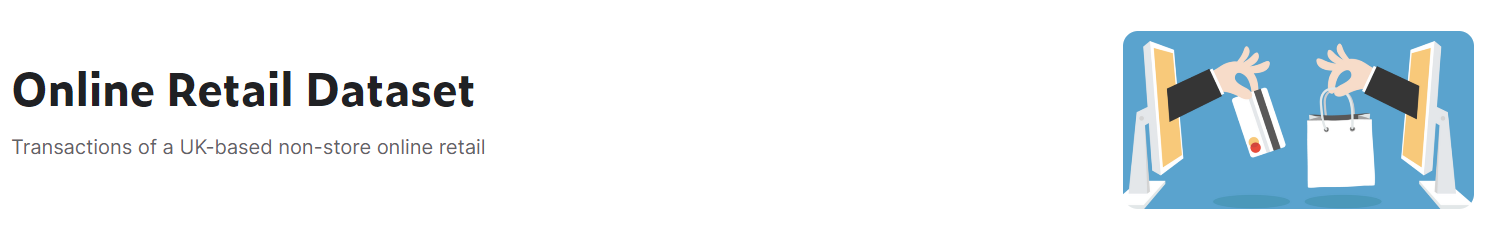
* https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ------------------------------------------------------ 훈련데이터
from sklearn.datasets import load_iris
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
# -------------------------------------------------------------------------- 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# -------------------------------------------------------------------------- 인코딩
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# -------------------------------------------------------------------------- 모델
from sklearn.cluster import KMeans, DBSCAN
# -------------------------------------------------------------------------- 평가
from sklearn.metrics import silhouette_score
# -------------------------------------------------------------------------- 교차검증


import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 차트 관련 속성 (차트크기 ) -----------
# plt.rcParams['figure.figsize'] = (4, 2)
# plt.rcParams['font.size'] = 7

# Data Load
* df.info()
* df.shape
* df.head()

In [3]:
df = pd.read_csv("online_retail_samll.csv")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# EDA

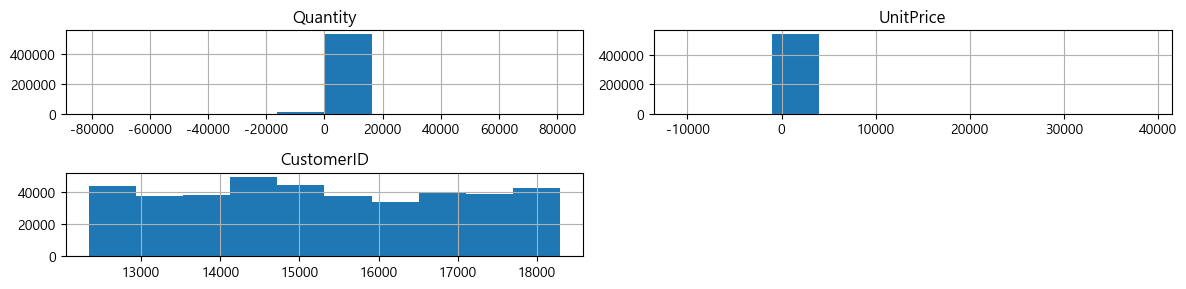

In [5]:
df.hist(figsize=(12,3))
plt.tight_layout()
plt.show()

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df[['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495478


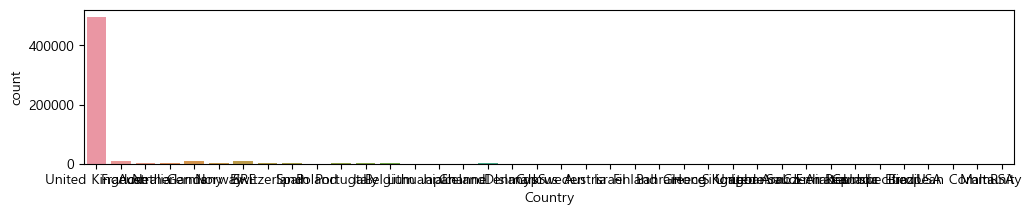

In [8]:
sns.countplot(x=df['Country'])
plt.gcf().set_size_inches(12, 2)
plt.show()

# 분석 데이터 선별
* 선별 조건
    * 정상건 : 'UnitPrice', 'Quantity' > 0 : 환불건도 같이 고려
    * 'Country' = 'United Kingdom'
    * 'Description' : StockCode가 존재, drop
    * 'CustomerID' : 비회원 drop

In [9]:
dfcp = df.copy()
# df = dfcp.copy()

In [10]:
drop_idx_list = []

In [11]:
# idx = df[(df['UnitPrice']<=0) | (df['Quantity']<=0)].index
# drop_idx_list.extend(idx)
# print(len(idx))
# df.drop(idx, axis=0, inplace=True)

* 국가 : 영국

In [12]:
idx = df[df['Country'] != 'United Kingdom'].index
drop_idx_list.extend(idx)
print(len(idx))
df.drop(idx, axis=0, inplace=True)

46431


* 비회원 고객 제외

In [13]:
print( df['CustomerID'].isna().sum() )
df.dropna( subset=['CustomerID'], inplace=True)  #, ignore_index=True)
df.reset_index()
df.head()
print(df.shape)

133600
(361878, 8)


In [14]:
dfcp.shape,  len(drop_idx_list)+133600, df.shape

((541909, 8), 180031, (361878, 8))

* 상품설명 제외

In [15]:
df.drop(['Country','Description'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    361878 non-null  object 
 1   StockCode    361878 non-null  object 
 2   Quantity     361878 non-null  int64  
 3   InvoiceDate  361878 non-null  object 
 4   UnitPrice    361878 non-null  float64
 5   CustomerID   361878 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 19.3+ MB


# 전처리 & 가공

## InvoiceNo

In [16]:
df['InvoiceNo'].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
548940       1
571830       1
C560391      1
576562       1
C568573      1
Name: InvoiceNo, Length: 19857, dtype: int64

In [17]:
df['InvoiceNo'].str[:1].value_counts()

5    354345
C      7533
Name: InvoiceNo, dtype: int64

In [18]:
a = df['InvoiceNo'].str.extract(r'([^0-9])').value_counts().values[0]
b = df.shape[0]
c = len(df)
a,b,c, (a/b)*100

(7533, 361878, 361878, 2.0816407739624956)

In [19]:
df['InvoiceNo'].str.extract(r'([^0-9])').notna().sum()

0    7533
dtype: int64

17841.0    136
17511.0    113
15311.0    112
14410.0     93
13798.0     90
Name: CustomerID, dtype: int64


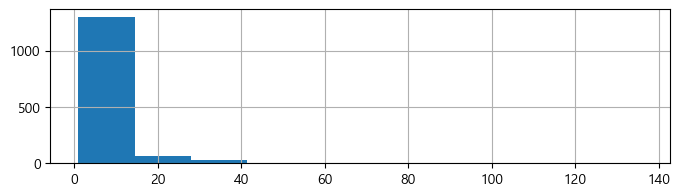

In [20]:
cidx = df[df['InvoiceNo'].str[:1] =='C'].index
# print(  len(cidx)  )
print(  df.loc[cidx, 'CustomerID'].value_counts().sort_values(ascending=False).head() )
df.loc[cidx, 'CustomerID'].value_counts().sort_values(ascending=False).hist(figsize=(8,2))
plt.show()

## 취소 주문 : 구분자
* 파생피쳐 

In [21]:
df['cancel'] = df['InvoiceNo'].str.extract('([^0-9])')
df['cancel'] = df['cancel'].apply(lambda x: 1 if x == 'C' else 0)
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,cancel
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,0
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,0
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,0
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,0
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,0


## UnitPrice
* UnitPrice <= 0 : drop

* 취소 : InvoiceNo가 C로 시작
    * 취소 데이터는 Quantity가 모두 음수인가?
    * 취소 데이터는 UnitPrice가 모두 음수인가?

In [22]:
#모든 취소건은 Quantity가 음수값
df[ (df['InvoiceNo'].str[:1] =='C') & (df['Quantity']> 0)]   

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,cancel


In [23]:
#모든 취소건은 UnitPrice 그데로 유지
df[ (df['InvoiceNo'].str[:1] =='C') & (df['UnitPrice']> 0)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,cancel
141,C536379,D,-1,2010-12-01 09:41:00,27.50,14527.0,1
154,C536383,35004C,-1,2010-12-01 09:49:00,4.65,15311.0,1
235,C536391,22556,-12,2010-12-01 10:24:00,1.65,17548.0,1
236,C536391,21984,-24,2010-12-01 10:24:00,0.29,17548.0,1
237,C536391,21983,-24,2010-12-01 10:24:00,0.29,17548.0,1
...,...,...,...,...,...,...,...
540449,C581490,23144,-11,2011-12-09 09:57:00,0.83,14397.0,1
541541,C581499,M,-1,2011-12-09 10:28:00,224.69,15498.0,1
541715,C581568,21258,-5,2011-12-09 11:57:00,10.95,15311.0,1
541716,C581569,84978,-1,2011-12-09 11:58:00,1.25,17315.0,1


* UnitPrice가 0원 음수인 경우?
    * 쿠폰, 예치금 사용???

In [24]:
# UnitPrice가 0원 음수인 경우?
df[df['UnitPrice'] <= 0]['CustomerID'].value_counts().head(3)

13081.0    4
13985.0    2
16560.0    1
Name: CustomerID, dtype: int64

In [25]:
df[ (df['CustomerID'] == 13081) & (df['UnitPrice']<=0) ]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,cancel
47068,540372,22090,24,2011-01-06 16:41:00,0.0,13081.0,0
47070,540372,22553,24,2011-01-06 16:41:00,0.0,13081.0,0
454463,575579,22437,20,2011-11-10 11:49:00,0.0,13081.0,0
454464,575579,22089,24,2011-11-10 11:49:00,0.0,13081.0,0


In [26]:
dfcp[dfcp['StockCode'].isin( ['22090', '22553', '22437', '22089'])] [:3]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
472,536408,22553,PLASTERS IN TIN SKULLS,12,2010-12-01 11:41:00,1.65,14307.0,United Kingdom
965,536520,22553,PLASTERS IN TIN SKULLS,1,2010-12-01 12:43:00,1.65,14729.0,United Kingdom


In [27]:
idx = df[df['UnitPrice'] <=0 ].index
print(  df.shape,  len(idx) )
df.drop(idx, axis=0, inplace=True)
print(  df.shape)

(361878, 7) 24
(361854, 7)


# RFM

* ref : https://ko.wikipedia.org/wiki/RFM
* 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법
* 마케팅에서 가장 많이 사용되고 있는 분석방법 중 하나
* 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법
    * <b>Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
    * <b>Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
    * <b>Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

## Recency
* 타입 : datetime64[ns]
* 파생피쳐(day_old)  : (max - min) + 1

In [28]:
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361854 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361854 non-null  object        
 1   StockCode    361854 non-null  object        
 2   Quantity     361854 non-null  int64         
 3   InvoiceDate  361854 non-null  datetime64[ns]
 4   UnitPrice    361854 non-null  float64       
 5   CustomerID   361854 non-null  float64       
 6   cancel       361854 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 22.1+ MB


In [29]:
df['InvoiceDate'].max(), df['InvoiceDate'].min()

(Timestamp('2011-12-09 12:49:00'), Timestamp('2010-12-01 08:26:00'))

In [30]:
df['day_old'] =  (df['InvoiceDate'].max()- df['InvoiceDate']).dt.days + 1
df = df.set_index('InvoiceDate')
df.tail()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,cancel,day_old
InvoiceDate,,,,,,,
2011-12-09 12:31:00,581585,22466,12,1.95,15804.0,0,1
2011-12-09 12:49:00,581586,22061,8,2.95,13113.0,0,1
2011-12-09 12:49:00,581586,23275,24,1.25,13113.0,0,1
2011-12-09 12:49:00,581586,21217,24,8.95,13113.0,0,1
2011-12-09 12:49:00,581586,20685,10,7.08,13113.0,0,1


## Frequency 
* 거래빈도: 얼마나 빈번하게 우리 상품을 구입했나?

In [31]:
# df[['InvoiceNo', 'StockCode']].value_counts().sort_values(ascending=False)
df[['InvoiceNo']].value_counts().sort_values(ascending=False)

InvoiceNo
576339       542
579196       533
580727       529
578270       442
573576       435
            ... 
C568560        1
563618         1
C568184        1
563660         1
569915         1
Length: 19854, dtype: int64

## Monetary 
* 거래규모: 총 금액은 어느 정도인가?

In [32]:
df['tot_price'] = df['Quantity'] * df['UnitPrice']
df.head(2)

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,cancel,day_old,tot_price
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,6,2.55,17850.0,0,374,15.30
2010-12-01 08:26:00,536365,71053,6,3.39,17850.0,0,374,20.34


In [33]:
(df['Quantity'] * df['UnitPrice']).sort_values(ascending=False)

InvoiceDate
2011-12-09 09:15:00    168469.60
2011-01-18 10:01:00     77183.60
2011-06-10 15:28:00     38970.00
2011-05-03 13:46:00      8142.75
2011-09-20 11:05:00      7144.72
                         ...    
2011-05-03 14:12:00     -6930.00
2011-05-03 12:51:00     -8142.75
2011-06-10 15:31:00    -38970.00
2011-01-18 10:17:00    -77183.60
2011-12-09 09:27:00   -168469.60
Length: 361854, dtype: float64

In [34]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'CustomerID',
       'cancel', 'day_old', 'tot_price'],
      dtype='object')

# Customer별  RFM 분석
* R(최근) : day_old.max():최초방문  , day_old.min():최근방문
* F(빈도) : InvoiceNo.count(), CustomerID.count()
* M(규모) : (Quantity*UnitPrice).sum()

In [35]:
df.head()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,cancel,day_old,tot_price
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,6,2.55,17850.0,0,374,15.30
2010-12-01 08:26:00,536365,71053,6,3.39,17850.0,0,374,20.34
2010-12-01 08:26:00,536365,84406B,8,2.75,17850.0,0,374,22.00
2010-12-01 08:26:00,536365,84029G,6,3.39,17850.0,0,374,20.34
2010-12-01 08:26:00,536365,84029E,6,3.39,17850.0,0,374,20.34


In [36]:
rfm_df = df.groupby('CustomerID').agg({'day_old':'min', 
                                       'InvoiceNo':'count', 
                                       'tot_price':'sum'})
rfm_df.columns = ['R','F','M']
rfm_df.head()

,R,F,M
CustomerID,,,
12346.0,326,2,0.00
12747.0,2,103,4196.01
12748.0,1,4641,29072.10
12749.0,4,231,3868.20
12820.0,3,59,942.34


In [37]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3949 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       3949 non-null   int64  
 1   F       3949 non-null   int64  
 2   M       3949 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 123.4 KB


# 학습 & 평가

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [39]:
X = rfm_df

model = KMeans(n_clusters=3, random_state=1111)
model.fit(X)
pred = model.predict(X)
print(model.inertia_)  #(가장가까운헤더 ~ 샘플) 간의 거리 합
sscore = silhouette_score(X, model.labels_, random_state=1111)
print ( f"실루엣스코어: {sscore:.4f}")


25731449696.507027
실루엣스코어: 0.9552


# PCA

[[-1.71531837e+03 -9.27850549e+01]
 [ 2.48233772e+03 -1.01213019e+01]
 [ 2.74124729e+04  4.19023556e+03]
 [ 2.15612857e+03  1.21016950e+02]
 [-7.71621496e+02 -1.32655417e+01]]
[9.98790450e-01 9.89559877e-04]
0.9997800101495483


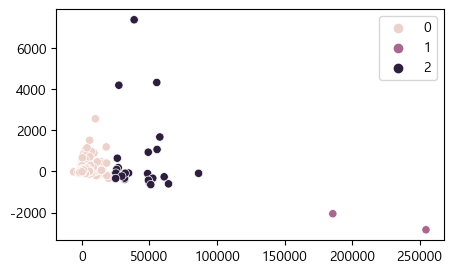

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=11)
X_pca = pca.fit_transform(X)
print(X_pca[:5])
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(5,3))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],  hue=pred)
plt.show()

# 공통함수

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

    
def my_chart(cluster_lists, X): 
    
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1111) 
        cluster_labels = kmeans.fit_predict(X)
        
        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        # X['pred_cluster_label'] = cluster_labels
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )

        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")
        


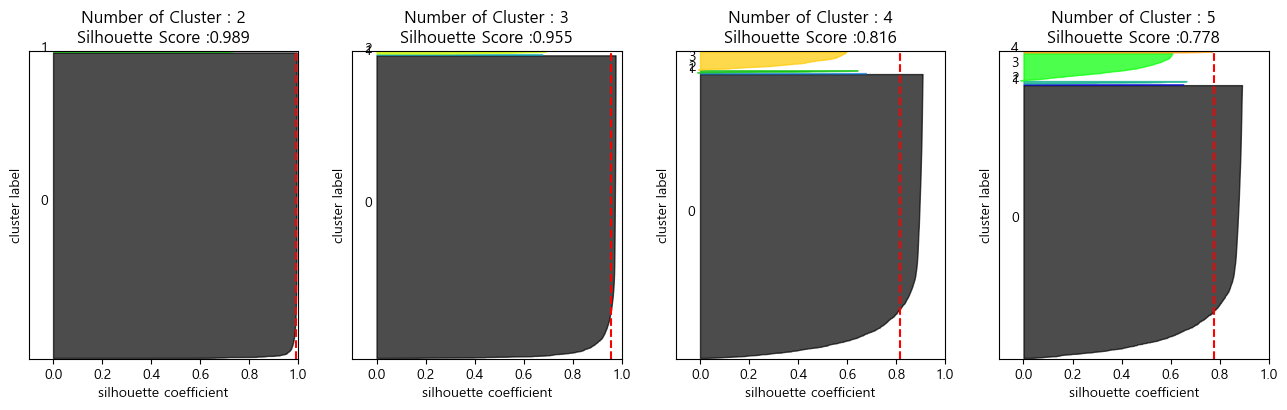

In [42]:
X = rfm_df
my_chart([2,3,4,5], X)

In [43]:
pred_dict = {}
def my_cluster(X, k_list=None):
    if bool(k_list) == False :
        k_list = [2,3,4,5,6]
    for k in k_list:
        model = KMeans(n_clusters=k, random_state=1111)
        model.fit(X)
        pred = model.predict(X)
        # print(model.inertia_)  #(가장가까운헤더 ~ 샘플) 간의 거리 합
        pred_dict[k] = pred

        
        sscore = silhouette_score(X, model.labels_, random_state=1111)
        print ( f"{k} 실루엣스코어: {sscore:.4f}")
        
        pca = PCA(n_components=2, random_state=11)
        X_pca = pca.fit_transform(X)
        # print(X_pca[:5])
        # print(pca.explained_variance_ratio_)
        # print(pca.explained_variance_ratio_.sum())

        #--- 엘보차트용
        i_list.append( [k, model.inertia_] )

        plt.figure(figsize=(5,3))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],  hue=pred)
        plt.show()

2 실루엣스코어: 0.9895


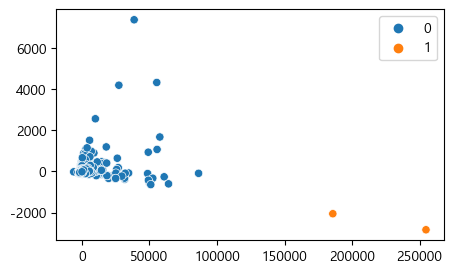

3 실루엣스코어: 0.9552


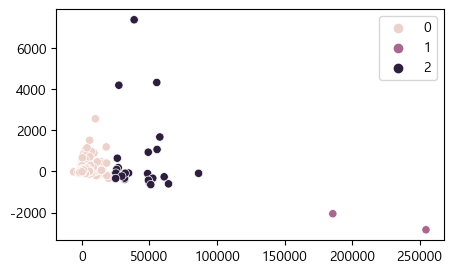

4 실루엣스코어: 0.8161


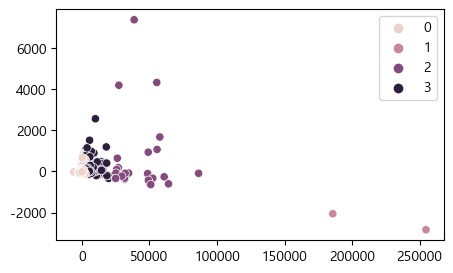

5 실루엣스코어: 0.7778


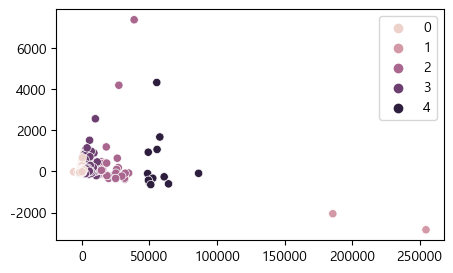

6 실루엣스코어: 0.7051


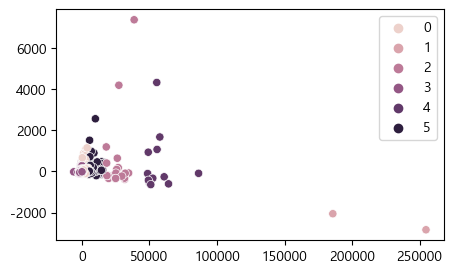

In [44]:
X = rfm_df
i_list = []
my_cluster(X)

In [45]:
X_log = np.log1p(X)
X_log.fillna(0, inplace=True)
X_log.head()

,R,F,M
CustomerID,,,
12346.0,5.789960,1.098612,0.000000
12747.0,1.098612,4.644391,8.342128
12748.0,0.693147,8.442901,10.277569
12749.0,1.609438,5.446737,8.260803
12820.0,1.386294,4.094345,6.849427


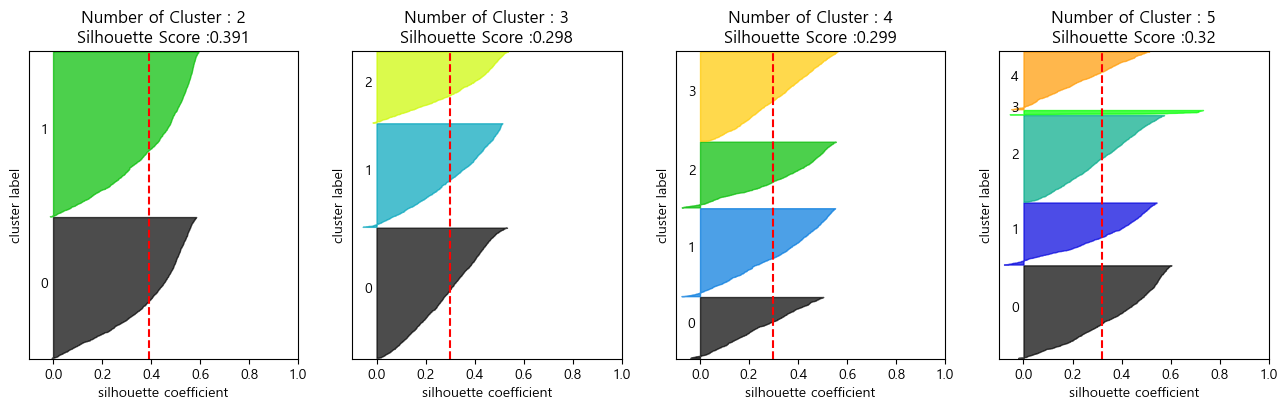

In [46]:
my_chart([2,3,4,5], X_log)

2 실루엣스코어: 0.3913


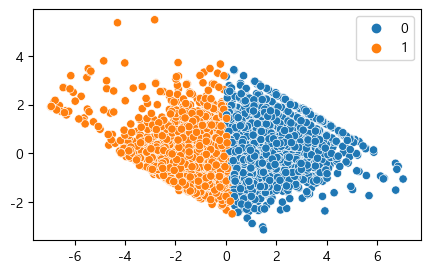

3 실루엣스코어: 0.2979


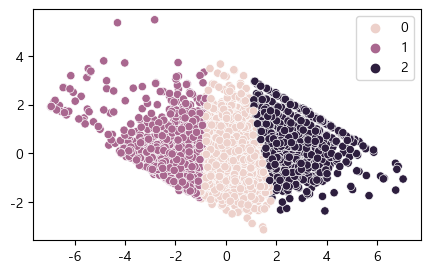

4 실루엣스코어: 0.2994


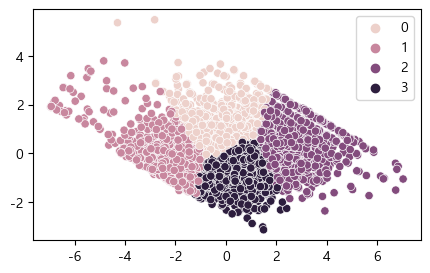

5 실루엣스코어: 0.3198


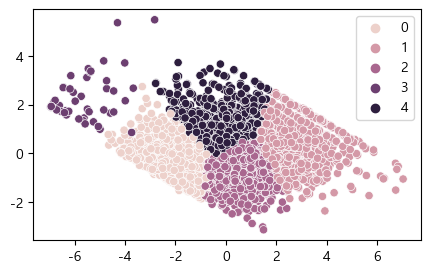

6 실루엣스코어: 0.2827


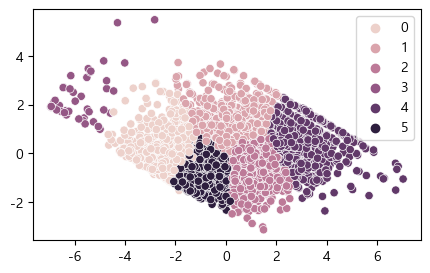

In [47]:
i_list = []

my_cluster(X_log)

# 고객분석
* 엘보우 차트를 사용한 적정 K값(군집수)
* 각 군집별(회원) 성향 분석

In [48]:
i_list

[[2, 11668.534247650892],
 [3, 9140.518415539022],
 [4, 7666.014001288833],
 [5, 6269.469475738328],
 [6, 5407.35393929619]]

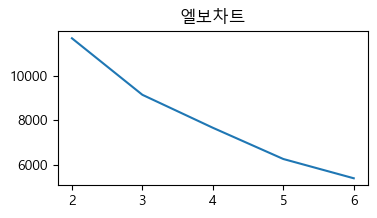

In [49]:
temp = pd.DataFrame(i_list, columns=['k','iv'])
plt.figure(figsize=(4,2))
plt.plot(temp['k'], temp['iv']) 
plt.title("엘보차트")
plt.show()


3 실루엣스코어: 0.3971


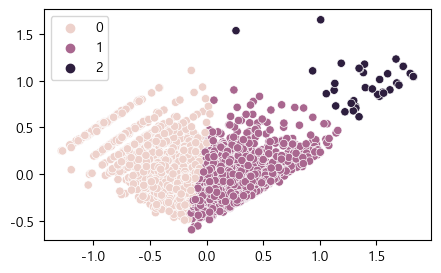

In [50]:
i_list = []
my_cluster(np.log1p(X_log), k_list=[3])

# K=3

In [51]:
MY_K__ = 4

In [52]:
pred_dict[MY_K__]

array([1, 2, 2, ..., 0, 2, 3])

In [53]:
X_exp = np.expm1(X_log)
X_exp['pred_cluster'] = pred_dict[MY_K__]
X_exp['F_M'] = np.round(X_exp['M'] / X_exp['F'] , 1)
X_exp['F_M_R'] = np.round(X_exp['F_M'] / X_exp['R'] , 1)
X_exp.head()

,R,F,M,pred_cluster,F_M,F_M_R
CustomerID,,,,,,
12346.0,326.0,2.0,0.00,1,0.0,0.0
12747.0,2.0,103.0,4196.01,2,40.7,20.3
12748.0,1.0,4641.0,29072.10,2,6.3,6.3
12749.0,4.0,231.0,3868.20,2,16.7,4.2
12820.0,3.0,59.0,942.34,2,16.0,5.3


In [54]:
X_exp.groupby('pred_cluster').mean()

,R,F,M,F_M,F_M_R
pred_cluster,,,,,
0,23.970960,30.015152,465.350341,33.707955,4.197348
1,200.392826,14.987752,258.408374,37.391076,0.263955
2,10.971897,263.322014,5398.353806,28.559953,8.174005
3,90.609483,82.822414,1297.952330,23.872069,0.386207


## 우수회원

In [55]:
len(X_exp) ,   len(X_exp[X_exp['pred_cluster'] == 2]), len(X_exp[X_exp['pred_cluster'] == 0])

(3949, 854, 792)

In [56]:
(854+792) / 3949 

0.41681438338819954

## 휴면회원

In [57]:
len(X_exp) ,   len(X_exp[X_exp['pred_cluster'] == 1])

(3949, 1143)

In [58]:
1143 / 3949 

0.2894403646492783